# Линеаризованные метрики: повышаем чувствительность A/B-теста

В 2018 году исследователи из Яндекса предложили мощный и при этом простой метод анализа метрик-отношений (например, CTR), который позволяет значительно повысить чувствительность теста.

## Основная идея метода

Мы знаем, что классический поюзерный CTR (`likes / views`) — шумная и нестабильная метрика, особенно у пользователей с малым числом просмотров.

Чтобы решить эту проблему, можно использовать **линеаризованные метрики** — более устойчивую альтернативу:

### Шаг 1: Рассчитываем общий CTR по контрольной группе
$$
CTR_{control} = \frac{\text{sum}(likes)}{\text{sum}(views)}
$$

### Шаг 2: Строим новую метрику для каждого пользователя
$$
\text{linearized\_likes} = likes - CTR_{control} \cdot views
$$

### Шаг 3: Применяем t-тест к новой метрике
Сравниваем группы по метрике `linearized_likes`.  
Если тест показывает значимость — значит, есть эффект и в исходной метрике (например, в CTR или общем числе лайков).

> В отличие от сглаженного CTR, этот метод имеет **теоретические гарантии**: если тест по `linearized_likes` значим, то он будет значим и по суммарному CTR (при достаточном размере выборки).

---

## Почему это круто?

- **Увеличение чувствительности теста:** Метод снижает дисперсию и делает тест более мощным.
- **Простота реализации:** Достаточно одного значения `CTR_control`, чтобы рассчитать метрику на уровне пользователя.
- **Работает с метриками-отношениями:** Идеально подходит для CTR, CR и других отношений вида `x/y`.

---

## Ваша задача

МЫ будем сравнивать группы по метрике `linearized_likes` и анализировать, как она влияет на результаты теста:

---

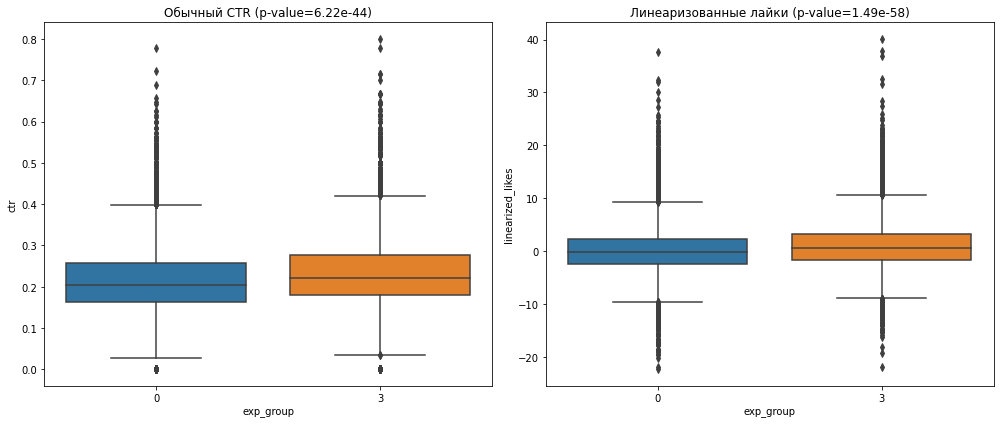


Результаты сравнения групп 0 и 3:
1. CTR контрольной группы: 0.2098
2. p-value (обычный CTR): 6.22e-44
3. p-value (линеаризованные лайки): 1.49e-58



In [3]:
import pandahouse as ph
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Настройки подключения к ClickHouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250520'
}

def linearized_likes_test(control_group, test_group, start_date, end_date):
    """
    Реализация метода линеаризованных лайков
    
    Параметры:
    - control_group: номер контрольной группы (например, 0)
    - test_group: номер тестовой группы (например, 3)
    - start_date, end_date: даты в формате 'YYYY-MM-DD'
    """
    
    # 1. Получаем общий CTR контрольной группы
    ctrl_ctr_query = f"""
    SELECT 
        sum(action = 'like') / sum(action = 'view') as ctr_control
    FROM simulator_20250520.feed_actions
    WHERE exp_group = {control_group}
      AND toDate(time) BETWEEN '{start_date}' AND '{end_date}'
    """
    ctrl_ctr = ph.read_clickhouse(ctrl_ctr_query, connection=connection)['ctr_control'].iloc[0]
    
    # 2. Получаем данные по пользователям обеих групп
    data_query = f"""
    SELECT 
        user_id,
        exp_group,
        sum(action = 'like') as likes,
        sum(action = 'view') as views
    FROM simulator_20250520.feed_actions
    WHERE exp_group IN ({control_group}, {test_group})
      AND toDate(time) BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY user_id, exp_group
    """
    df = ph.read_clickhouse(data_query, connection=connection)
    
    # 3. Рассчитываем метрики
    df['ctr'] = df['likes'] / df['views']
    df['linearized_likes'] = df['likes'] - ctrl_ctr * df['views']
    
    # 4. Разделяем данные на группы
    control_data = df[df['exp_group'] == control_group]
    test_data = df[df['exp_group'] == test_group]
    
    # 5. Проводим t-тесты
    # Для обычного CTR
    t_test_ctr = stats.ttest_ind(control_data['ctr'], test_data['ctr'], equal_var=False)
    
    # Для линеаризованных лайков
    t_test_lin = stats.ttest_ind(control_data['linearized_likes'], 
                               test_data['linearized_likes'], 
                               equal_var=False)
    
    # 6. Визуализация
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='exp_group', y='ctr', data=df)
    plt.title(f'Обычный CTR (p-value={t_test_ctr.pvalue:.2e})')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='exp_group', y='linearized_likes', data=df)
    plt.title(f'Линеаризованные лайки (p-value={t_test_lin.pvalue:.2e})')
    
    plt.tight_layout()
    plt.show()
    
    # 7. Возвращаем результаты
    return {
        'control_group': control_group,
        'test_group': test_group,
        'control_ctr': ctrl_ctr,
        'ctr_pvalue': t_test_ctr.pvalue,
        'linearized_pvalue': t_test_lin.pvalue,
        'data': df
    }

# Пример использования для групп 0 и 3
results = linearized_likes_test(control_group=0, 
                              test_group=3, 
                              start_date='2025-05-02', 
                              end_date='2025-05-08')

print(f"""
Результаты сравнения групп {results['control_group']} и {results['test_group']}:
1. CTR контрольной группы: {results['control_ctr']:.4f}
2. p-value (обычный CTR): {results['ctr_pvalue']:.2e}
3. p-value (линеаризованные лайки): {results['linearized_pvalue']:.2e}
""")